In [2]:
import numpy as np
from scipy import signal
import scipy.spatial.distance as distfuncs
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path

import sys
sys.path.append('../')
import irutilities as irutil
import sf_func as sf

In [3]:
# Load ir data
sessionName = "S32-M441_npy"
sessionPath = Path('..').joinpath(sessionName)
posAll, posSrc, irAll = irutil.loadIR(sessionPath)

numAll = posAll.shape[0]
numSrc = posSrc.shape[0]

posAllX = np.unique(posAll[:,0].round(4))
posAllY = np.unique(posAll[:,1].round(4))
numAllXY = (posAllX.shape[0], posAllY.shape[0])

# Sampling rate (original)
samplerate_raw = 48000

In [4]:
# Downsampling
downSampling = 6
irAll = signal.resample_poly(irAll, up=1, down=downSampling, axis=-1)
samplerate = samplerate_raw // downSampling
print('samplerate (Hz): ', samplerate)

posAllXY, _, idxAllXY = irutil.sortIR(posAll[:,0:2], irAll, numAllXY, posAllX, posAllY)

# Truncation of IRs
irLen = 4096
irAll = np.transpose(irAll, (2,1,0))
irAll = irAll[0:irLen,:,:]
print('ir length:', irLen)

samplerate (Hz):  8000
ir length: 4096


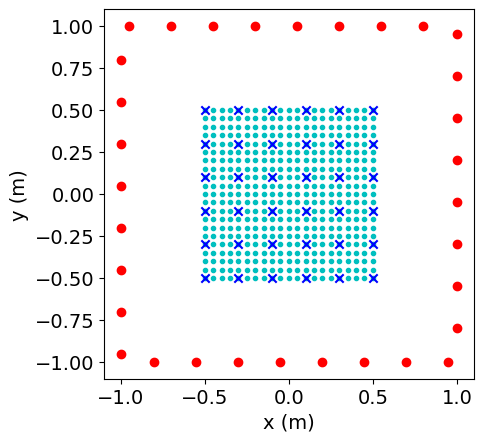

In [5]:
# Target region and evaluation points
dimsEval = [1.0, 1.0]
idxEval = np.where( (np.abs(posAll[:,0])<=dimsEval[0]/2) & (np.abs(posAll[:,1])<=dimsEval[1]/2) )[0]
posEval = posAll[idxEval,:]
numEval = posEval.shape[0]
posEvalX = np.unique(posEval[:,0].round(4))
posEvalY = np.unique(posEval[:,1].round(4))
irEval = irAll[:,idxEval,:]

# Control points
#xGrid = np.arange(-dimsEval[0]/2+0.05, dimsEval[0]/2, 0.3)
#yGrid = np.arange(-dimsEval[1]/2+0.05, dimsEval[1]/2, 0.3)
xGrid = np.arange(-dimsEval[0]/2, dimsEval[0]/2+0.05, 0.2)
yGrid = np.arange(-dimsEval[1]/2, dimsEval[1]/2+0.05, 0.2)

xIdx = []
for ii in np.arange(xGrid.shape[0]):
    xIdx.append(np.where( np.isclose(posEval[:,0], xGrid[ii]) ))
yIdx = []
for ii in np.arange(yGrid.shape[0]):
    yIdx.append(np.where( np.isclose(posEval[:,1], yGrid[ii]) ))

idxMic = np.intersect1d(xIdx, yIdx)
numMic = idxMic.shape[0]
posMic = posAll[idxMic,:]

# IR at control points
irMic = irAll[:,idxMic,:]

# Plot geometry
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()
ax.scatter(posEval[:,0], posEval[:,1], marker='.', color='c')
ax.scatter(posMic[:,0], posMic[:,1], marker='x', color='b')
ax.scatter(posSrc[:,0], posSrc[:,1], marker='o', color='r')
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


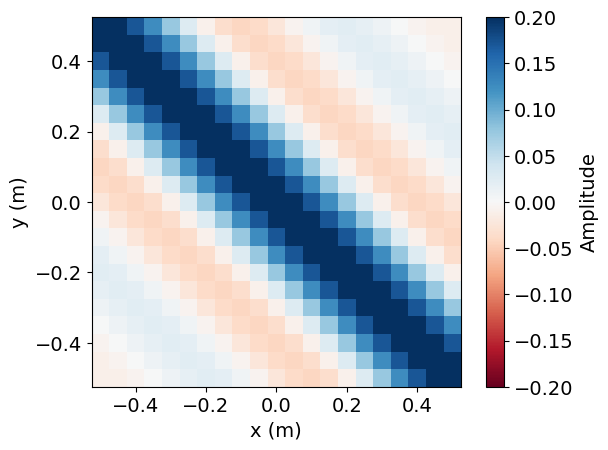

In [6]:
# FFT parameters
fftlen = 16384
freq = np.arange(1,int(fftlen/2)+1)/fftlen*samplerate  # Frequency
numFreq = freq.shape[0]  # Number of frequency bins
c = 341.9  # Sound speed
k = 2.0 * np.pi * freq / c  # Wavenumber

# Filter parameters
smplShift = 4096
filterLen = 8192

# Lowpass filter
maxFreq = 900
h = signal.firwin(numtaps=64, cutoff=maxFreq, fs=samplerate)

# Desired sound field
pwAng = (np.pi/4, np.pi/2)
des = sf.planewave(1.0, pwAng[0], pwAng[1], posMic[:,0].T, posMic[:,1].T, posMic[:,2].T, k[:,None])

synTrueAll_f = sf.planewave(1.0, pwAng[0], pwAng[1], posAll[:,0].T, posAll[:,1].T, posAll[:,2].T, k[:,None])
synTrueAll_f = np.concatenate( (np.zeros((1,numAll)), synTrueAll_f, synTrueAll_f[int(fftlen/2)-2::-1,:].conj()) )
synTrueAll = np.fft.ifft(synTrueAll_f, n=fftlen, axis=0).real
synTrueAll = np.concatenate((synTrueAll[fftlen-smplShift:fftlen,:], synTrueAll[:fftlen-smplShift,:]))
synTrueAll = signal.filtfilt(h, 1, synTrueAll, axis=0)

synTrue = synTrueAll[:,idxEval]
distTrue = synTrueAll[:,idxAllXY]

# Draw pressure distribution
tIdx = smplShift

xx, yy = np.meshgrid(posEvalX, posEvalY)

fig, ax = plt.subplots()
color = plt.pcolormesh(xx, yy, distTrue[tIdx,:,:].T, cmap='RdBu', shading='auto', vmin=-0.2, vmax=0.2)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("control_true.pdf")
plt.show()


In [7]:
# Transfer function matrix
tfMic = np.fft.fft(irMic, n=fftlen, axis=0)
G = tfMic[1:int(fftlen/2)+1,:,:]  # Transfer functions of positive frequencies

# Regularization parameter ratio
regRatio = 1e-3

## Pressure matching

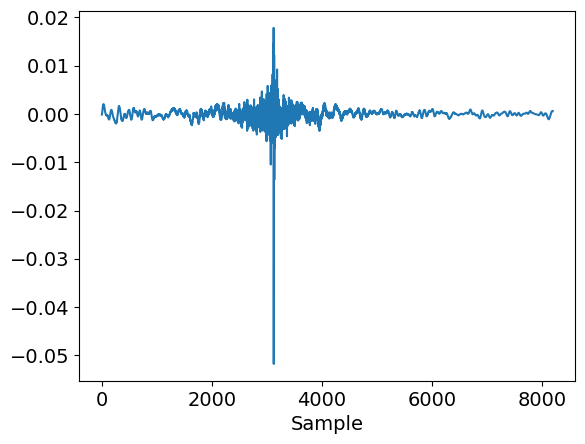

In [8]:
eigPM, _ = np.linalg.eig(np.transpose(G.conj(),(0,2,1)) @ G)
condPM = np.sqrt(eigPM[:,0]/eigPM[:,-1])
regPM = eigPM[:,0] * regRatio

drvPM = np.squeeze( np.linalg.inv(np.transpose(G.conj(), (0,2,1)) @ G + regPM[:,None,None] * np.eye(numSrc)) @ np.transpose(G.conj(), (0,2,1)) @ des[:,:,None] )
drvPM = np.concatenate( (np.zeros((1,numSrc)), drvPM, drvPM[int(fftlen/2)-2::-1,:].conj()) )

filterPM = np.fft.ifft(drvPM, n=fftlen, axis=0).real
filterPM = np.concatenate((filterPM[fftlen-smplShift:fftlen,:], filterPM[:filterLen-smplShift,:]))

# Plot filter
fig, ax = plt.subplots()
ax.plot(filterPM[:,0])
plt.xlabel('Sample')
plt.show()

## Weighted pressure matching
* S. Koyama and K. Arikawa, "Weighted Pressure Matching Based on Kernel Interpolation for Sound Field Reproduction," Proc. ICA, 2022.
* S. Koyama, K. Kimura, and K. Arikawa, "Weighted Pressure and Mode Matching for Sound Field Reproduction: Theoretical and Experimental Comparisons," J. AES, 2022.

Starting monte carlo integration 
 Samples per block:  20 
Total samples:  1000
Block  0
Block  1
Block  2
Block  3
Block  4
Block  5
Block  6
Block  7
Block  8
Block  9
Block  10
Block  11
Block  12
Block  13
Block  14
Block  15
Block  16
Block  17
Block  18
Block  19
Block  20
Block  21
Block  22
Block  23
Block  24
Block  25
Block  26
Block  27
Block  28
Block  29
Block  30
Block  31
Block  32
Block  33
Block  34
Block  35
Block  36
Block  37
Block  38
Block  39
Block  40
Block  41
Block  42
Block  43
Block  44
Block  45
Block  46
Block  47
Block  48
Block  49
Finished!!


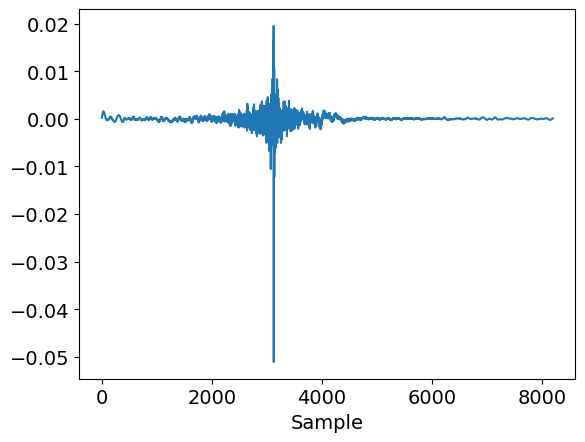

In [9]:
mcNumPoints = 1000
Wpm = sf.weightWPM(k, posMic, mcNumPoints, dimsEval)

# Regularization parameter
eigWPM, _ = np.linalg.eig(np.transpose(G.conj(),(0,2,1)) @ Wpm @ G)
condWPM = np.sqrt(eigWPM[:,0]/eigWPM[:,-1])
regWPM = eigWPM[:,0] * regRatio

drvWPM = np.squeeze( np.linalg.inv(np.transpose(G.conj(),(0,2,1)) @ Wpm @ G + regWPM[:,None,None] * np.eye(numSrc)[None,:,:]) @ np.transpose(G.conj(),(0,2,1)) @ Wpm @ des[:,:,None] )
drvWPM = np.concatenate( (np.zeros((1,numSrc)), drvWPM, drvWPM[int(fftlen/2)-2::-1,:].conj()) )

filterWPM = np.fft.ifft(drvWPM, n=fftlen, axis=0).real
filterWPM = np.concatenate((filterWPM[fftlen-smplShift:fftlen,:], filterWPM[:filterLen-smplShift,:]))

# Plot filter
fig, ax = plt.subplots()
ax.plot(filterWPM[:,0])
plt.xlabel('Sample')
plt.show()

## Mode matching and Weighted mode matching
* N. Ueno, S. Koyama, and H. Saruwatari, “Three-Dimensional Sound Field Reproduction Based on Weighted Mode-Matching Method,” IEEE/ACM Trans. ASLP, DOI: 10.1109/TASLP.2019.2934834, 2019.

Frequency: 0/8192
Frequency: 1/8192
Frequency: 2/8192
Frequency: 3/8192
Frequency: 4/8192
Frequency: 5/8192
Frequency: 6/8192
Frequency: 7/8192
Frequency: 8/8192
Frequency: 9/8192
Frequency: 10/8192
Frequency: 11/8192
Frequency: 12/8192
Frequency: 13/8192
Frequency: 14/8192
Frequency: 15/8192
Frequency: 16/8192
Frequency: 17/8192
Frequency: 18/8192
Frequency: 19/8192
Frequency: 20/8192
Frequency: 21/8192
Frequency: 22/8192
Frequency: 23/8192
Frequency: 24/8192
Frequency: 25/8192
Frequency: 26/8192
Frequency: 27/8192
Frequency: 28/8192
Frequency: 29/8192
Frequency: 30/8192
Frequency: 31/8192
Frequency: 32/8192
Frequency: 33/8192
Frequency: 34/8192
Frequency: 35/8192
Frequency: 36/8192
Frequency: 37/8192
Frequency: 38/8192
Frequency: 39/8192
Frequency: 40/8192
Frequency: 41/8192
Frequency: 42/8192
Frequency: 43/8192
Frequency: 44/8192
Frequency: 45/8192
Frequency: 46/8192
Frequency: 47/8192
Frequency: 48/8192
Frequency: 49/8192
Frequency: 50/8192
Frequency: 51/8192
Frequency: 52/8192
Fre

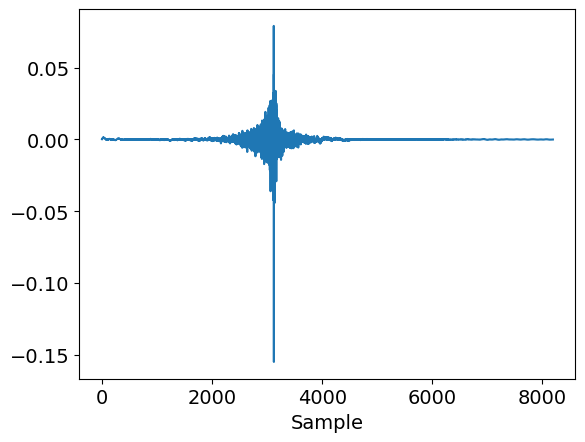

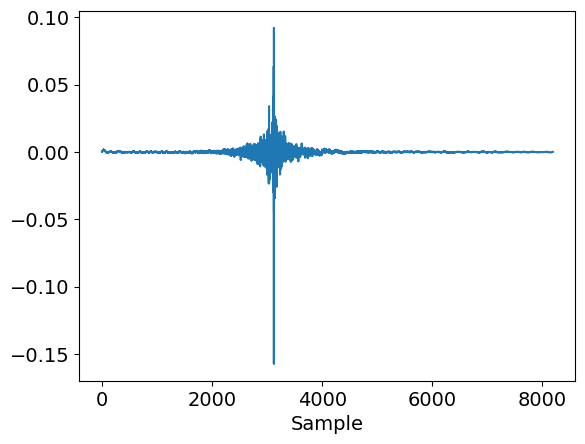

In [10]:
# Estimation of spherical wavefunction expansion coefficients of loudspeaker transfer functions
posEst = np.zeros((1,3))  # Origin
orderMic = 0  # Pressure microphone
orderEst = 12  # Maximum order for estimation
coefMic = np.ones((1, numMic), dtype=complex)  # Expansion coefficients of microphone directivity

# Load estimation operator
fileName = 'coefEstOp_o%d_m%d_f%d.npy' % (orderEst, numMic, numFreq)
filePath = Path('__file__').parent.joinpath(fileName)
coefEstOpr = np.load(filePath)
# To generate (and save) a new estimation operator, uncomment the following lines 
# coefEstOpr = sf.coefEstOprGen(posEst, orderEst, posMic, orderMic, coefMic, k)
# np.save(filePath, coefEstOpr)

# Estimation of expantion coefficients of loudspeaker transfer functions
GMode = np.zeros((k.shape[0], (orderEst+1)**2, numSrc), dtype=complex)
for ss in np.arange(numSrc):
    sigG = G[:, :, ss]
    GMode[:, :, ss] = np.squeeze( coefEstOpr @ sigG[:, :, None] )

# Expansion coefficients of desired sound field
desMode = sf.planewave_mode(orderEst, 1.0, pwAng[0], pwAng[1], 0., 0., 0., k[None,:]).T

# Weighting matrix for weighted mode-matching
fileName = 'WeightMode_o%d_xyplane_f%d.npy' % (orderEst, numFreq)
filePath = Path('__file__').parent.joinpath(fileName)
WMode = np.load(filePath)
# To generate (and save) a new weighting matrix for weighted mode-matching, uncomment the following lines
# mcNumPoints = 1000
# WMode = sf.weightWMM(k, orderEst, mcNumPoints, dimsEval)
# np.save(filePath, WMode)

# Mask matrix for Mixed-order mode matching
orderMM = np.minimum( orderEst, np.ceil(k * dimsEval[0] * np.sqrt(2) / 2).astype(int) )
n, m = sf.sph_harm_nmvec(orderEst)
WModeMM_vec = np.array(n - np.abs(m) < 1e-10).astype(int)
WModeMM = np.zeros((numFreq,(orderEst+1)**2,(orderEst+1)**2), dtype=int)
for ii in np.arange(numFreq):
    WModeMM[ii,0:(orderMM[ii]+1)**2,0:(orderMM[ii]+1)**2] = np.diag( WModeMM_vec[0:(orderMM[ii]+1)**2] )

# Regularization parameter
eigMM, _ = np.linalg.eig(np.transpose(GMode.conj(), (0,2,1)) @ WModeMM @ GMode)
condMM = np.sqrt(eigMM[:,0]/eigMM[:,-1])
regMM = eigMM[:,0] * regRatio
eigWMM, _ = np.linalg.eig(np.transpose(GMode.conj(), (0,2,1)) @ WMode @ GMode)
condWMM = np.sqrt(eigWMM[:,0]/eigWMM[:,-1])
regWMM = eigWMM[:,0] * regRatio

# Mode matching
drvMM = np.squeeze( np.linalg.inv(np.transpose(GMode.conj(), (0,2,1)) @ WModeMM @ GMode + regMM[:,None,None] * np.eye(numSrc)[None,:,:]) @ np.transpose(GMode.conj(), (0,2,1)) @ WModeMM @ desMode[:,:,None] )
drvMM = np.concatenate( (np.zeros((1,numSrc)), drvMM, drvMM[int(fftlen/2)-2::-1,:].conj()) )

filterMM = np.fft.ifft(drvMM, n=fftlen, axis=0).real
filterMM = np.concatenate((filterMM[fftlen-smplShift:fftlen,:], filterMM[:filterLen-smplShift,:]))

# Weighted mode-matching
drvWMM = np.squeeze( np.linalg.inv(np.transpose(GMode.conj(), (0,2,1)) @ WMode @ GMode + regWMM[:,None,None] * np.eye(numSrc)) @ np.transpose(GMode.conj(), (0,2,1)) @ WMode @ desMode[:,:,None] )
drvWMM = np.concatenate( (np.zeros((1,numSrc)), drvWMM, drvWMM[int(fftlen/2)-2::-1,:].conj()) )

filterWMM = np.fft.ifft(drvWMM, n=fftlen, axis=0).real
filterWMM = np.concatenate((filterWMM[fftlen-smplShift:fftlen,:], filterWMM[:filterLen-smplShift,:]))

# Plot filter
fig, ax = plt.subplots()
ax.plot(filterMM[:,0])
plt.xlabel('Sample')
plt.show()

fig, ax = plt.subplots()
ax.plot(filterWMM[:,0])
plt.xlabel('Sample')
plt.show()


[SDR] PM: 1.729126, WPM: 3.573527, MM: 2.426230, WMM: 3.476008


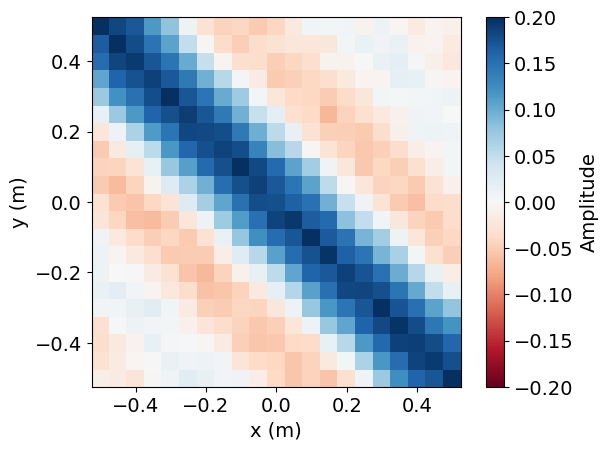

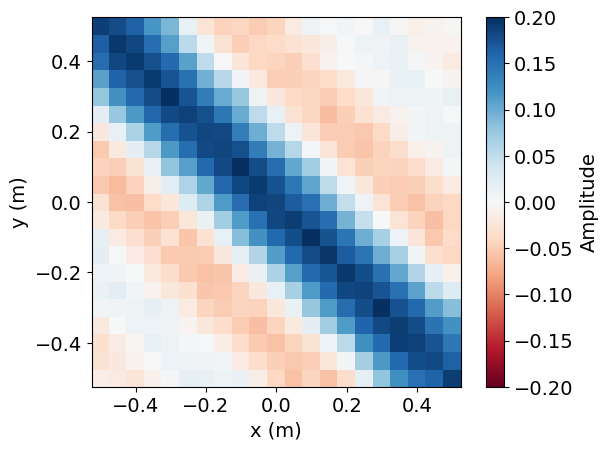

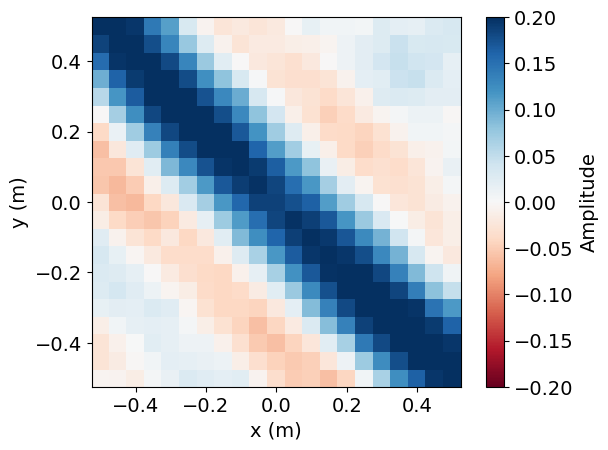

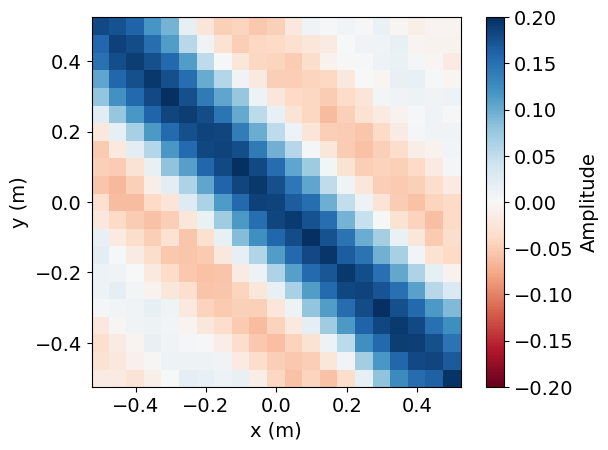

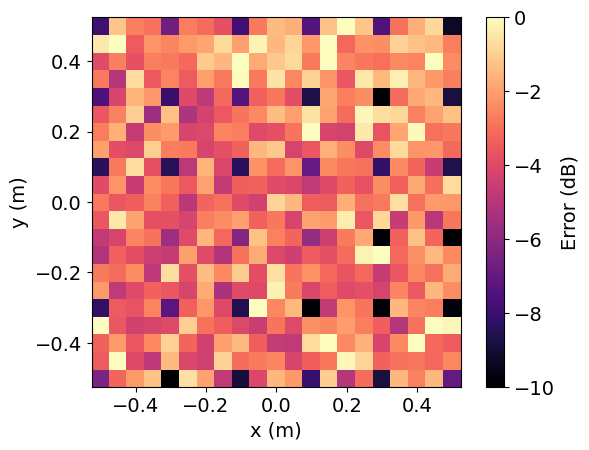

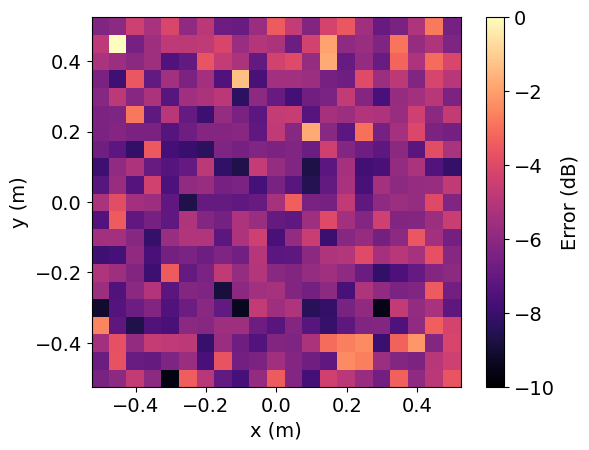

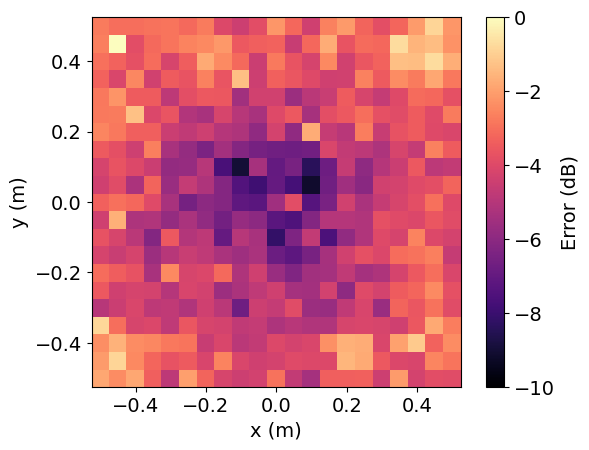

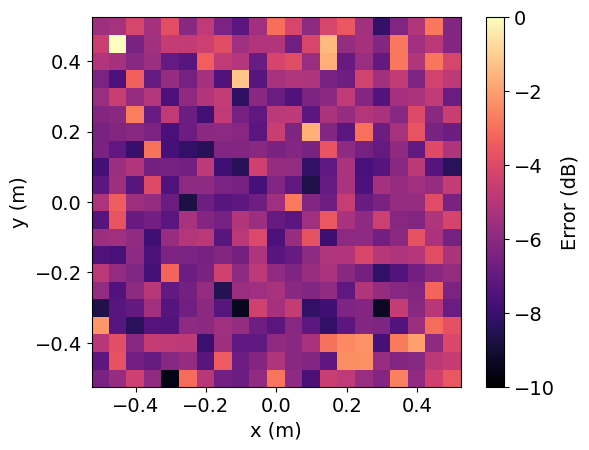

In [11]:
# Lowpass
sigPM = signal.filtfilt(h, 1, filterPM, axis=0)
sigWPM = signal.filtfilt(h, 1, filterWPM, axis=0)
sigMM = signal.filtfilt(h, 1, filterMM, axis=0)
sigWMM = signal.filtfilt(h, 1, filterWMM, axis=0)

# Convolution of filters
tfAll = np.fft.fft(irAll, n=fftlen, axis=0)

# Index of evaluation points for computing SDR
idxSDR = np.setdiff1d(idxEval, idxMic)

sigPM_f = np.fft.fft(sigPM, n=fftlen, axis=0)
synPM_All = np.fft.ifft(tfAll @ sigPM_f[:,:,None], n=fftlen, axis=0).real
synPM = np.squeeze(synPM_All[:,idxEval])
distPM = np.squeeze(synPM_All[:,idxAllXY])
errPM = np.sum( np.abs(distPM - distTrue) ** 2, axis=0) / np.sum( np.abs(distTrue) ** 2, axis=0)
SDR_PM = np.sum( np.sum( np.abs(synTrue[:,idxSDR]) ** 2) ) / np.sum( np.sum( np.abs(synPM[:,idxSDR] - synTrue[:,idxSDR]) ** 2) ) 

sigWPM_f = np.fft.fft(sigWPM, n=fftlen, axis=0)
synWPM_All = np.fft.ifft(tfAll @ sigWPM_f[:,:,None], n=fftlen, axis=0).real
synWPM = np.squeeze(synWPM_All[:,idxEval])
distWPM = np.squeeze(synWPM_All[:,idxAllXY])
errWPM = np.sum( np.abs(distWPM - distTrue) ** 2, axis=0) / np.sum( np.abs(distTrue) ** 2, axis=0)
SDR_WPM = np.sum( np.sum( np.abs(synTrue[:,idxSDR]) ** 2) ) / np.sum( np.sum( np.abs(synWPM[:,idxSDR] - synTrue[:,idxSDR]) ** 2) ) 

sigMM_f = np.fft.fft(sigMM, n=fftlen, axis=0)
synMM_All = np.fft.ifft(tfAll @ sigMM_f[:,:,None], n=fftlen, axis=0).real
synMM = np.squeeze(synMM_All[:,idxEval])
distMM = np.squeeze(synMM_All[:,idxAllXY])
errMM = np.sum( np.abs(distMM - distTrue) ** 2, axis=0) / np.sum( np.abs(distTrue) ** 2, axis=0)
SDR_MM = np.sum( np.sum( np.abs(synTrue[:,idxSDR]) ** 2) ) / np.sum( np.sum( np.abs(synMM[:,idxSDR] - synTrue[:,idxSDR]) ** 2) )

sigWMM_f = np.fft.fft(sigWMM, n=fftlen, axis=0)
synWMM_All = np.fft.ifft(tfAll @ sigWMM_f[:,:,None], n=fftlen, axis=0).real
synWMM = np.squeeze(synWMM_All[:,idxEval])
distWMM = np.squeeze(synWMM_All[:,idxAllXY])
errWMM = np.sum( np.abs(distWMM - distTrue) ** 2, axis=0) / np.sum( np.abs(distTrue) ** 2, axis=0)
SDR_WMM = np.sum( np.sum( np.abs(synTrue[:,idxSDR]) ** 2) ) / np.sum( np.sum( np.abs(synWMM[:,idxSDR] - synTrue[:,idxSDR]) ** 2) )

# Signal-to-distortion ration (SDR)
print('[SDR] PM: %f, WPM: %f, MM: %f, WMM: %f' % (SDR_PM, SDR_WPM, SDR_MM, SDR_WMM))

# Draw pressure distribution
fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, distPM[tIdx,:,:].T, cmap='RdBu', shading='auto', vmin=-0.2, vmax=0.2)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("control_syn_pm.pdf")

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, distWPM[tIdx,:,:].T, cmap='RdBu', shading='auto', vmin=-0.2, vmax=0.2)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("control_syn_wpm.pdf")

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, distMM[tIdx,:,:].T, cmap='RdBu', shading='auto', vmin=-0.2, vmax=0.2)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("control_syn_mm.pdf")

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, distWMM[tIdx,:,:].T, cmap='RdBu', shading='auto', vmin=-0.2, vmax=0.2)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("control_syn_wmm.pdf")

# Draw error distribution
fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, 10 * np.log10(errPM).T, cmap='magma', shading='auto', vmin=-10.0, vmax=0.0)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Error (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("control_error_pm.pdf")

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, 10 * np.log10(errWPM).T, cmap='magma', shading='auto', vmin=-10.0, vmax=0.0)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Error (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("control_error_wpm.pdf")

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, 10 * np.log10(errMM).T, cmap='magma', shading='auto', vmin=-10.0, vmax=0.0)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Error (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("control_error_mm.pdf")

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, 10 * np.log10(errWMM).T, cmap='magma', shading='auto', vmin=-10.0, vmax=0.0)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Error (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("control_error_wmm.pdf")

plt.show()